# Seismic attributes with `bruges`

In general `bruges` is not yet directly compatible with `xarray`'s objects. You can always pass the internal NumPy data from an `xarray.DataAarray` called `x` like:

    x.data
    
So it shouldn't cause too many problems.

In [1]:
import numpy as np
import segyio

ds = np.DataSource('../data')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/F3_8-bit_int.sgy'

with segyio.open(ds.open(url).name) as s:
    seismic = segyio.cube(s)
    
# Volume is int16. Turn it into floats.
seismic = (seismic / np.max(np.abs(seismic))).astype(float)
    
seismic.shape

(225, 300, 463)

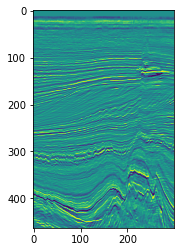

In [2]:
import matplotlib.pyplot as plt

plt.imshow(seismic[50].T)

We don't really *need* to do this, but let's turn this volume into an `xarray.DataArray` object like so:

In [3]:
import xarray as xr

i, x, t = seismic.shape

# I don't have the inline, xline numbers, so I'll just use the shape.
iline = np.arange(i)
xline = np.arange(x)
twt = np.arange(t) * 0.004

seismic_xr = xr.DataArray(seismic,
                          name='amplitude',
                          coords=[iline, xline, twt],
                          dims=['iline', 'xline', 'twt']
                          )

Later on, this will let us easily display attributes and seismic together, for example.

## Complex trace attributes

#### Envelope (aka reflection strength, instantaneous amplitude)

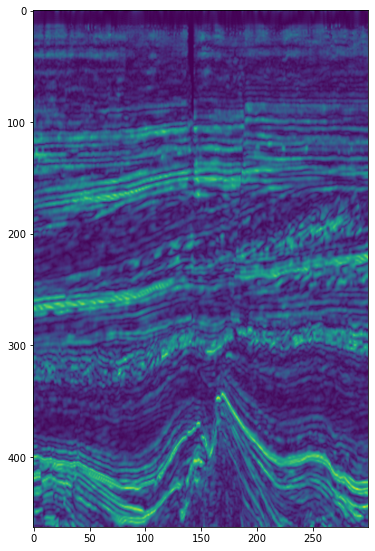

In [4]:
import bruges as bg

env = bg.attribute.envelope(seismic)

plt.figure(figsize=(6, 10))
plt.imshow(env[100].T, interpolation='bicubic')

#### Instantaneous phase

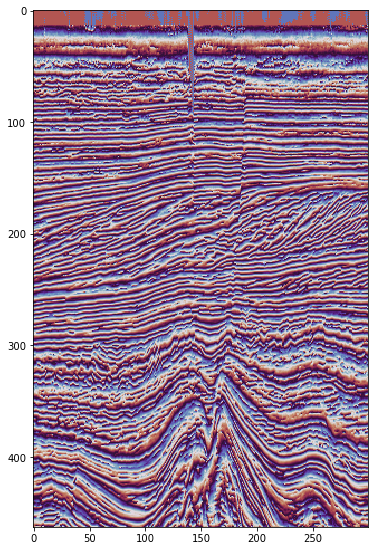

In [5]:
phase = bg.attribute.instantaneous_phase(seismic)

plt.figure(figsize=(6, 10))
plt.imshow(phase[100].T, cmap='twilight_shifted', interpolation='none')
# Needs a circular cmap and no interpolation.

#### Instantaneous frequency

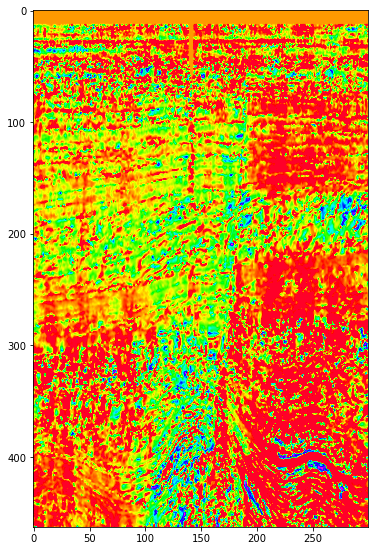

In [6]:
freq = bg.attribute.instantaneous_frequency(seismic, dt=0.004)

plt.figure(figsize=(6, 10))
plt.imshow(freq[100].T, cmap='gist_rainbow', interpolation='bicubic', vmin=-10)

#### Similarity (family including coherency, semblance, gradient structure tensor, etc.)

⚠️ This one takes quite a bit longer than the simpler attributes above, so I'll just compute on a sub-cube:

In [8]:
seismic.shape

(225, 300, 463)

In [ ]:
subcube = seismic[50:150, 120:220, :350]

# ⚠️ SLOW
semb = bg.attribute.similarity(subcube, duration=0.036, dt=0.004, kind='gst')

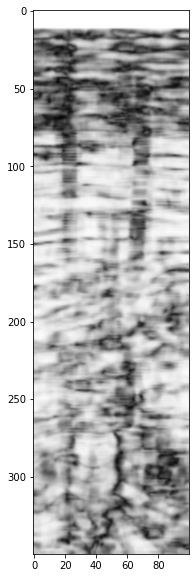

In [10]:
plt.figure(figsize=(6, 10))
plt.imshow(semb[50].T, cmap='gray', interpolation='bicubic')

## Attributes and `xarray`

Let's look at how to make this into an `xarray.DataArray`:

In [11]:
env_xr = xr.DataArray(seismic,
                          name='envelope',
                          coords=seismic_xr.coords,
                          dims=seismic_xr.dims,
                          )

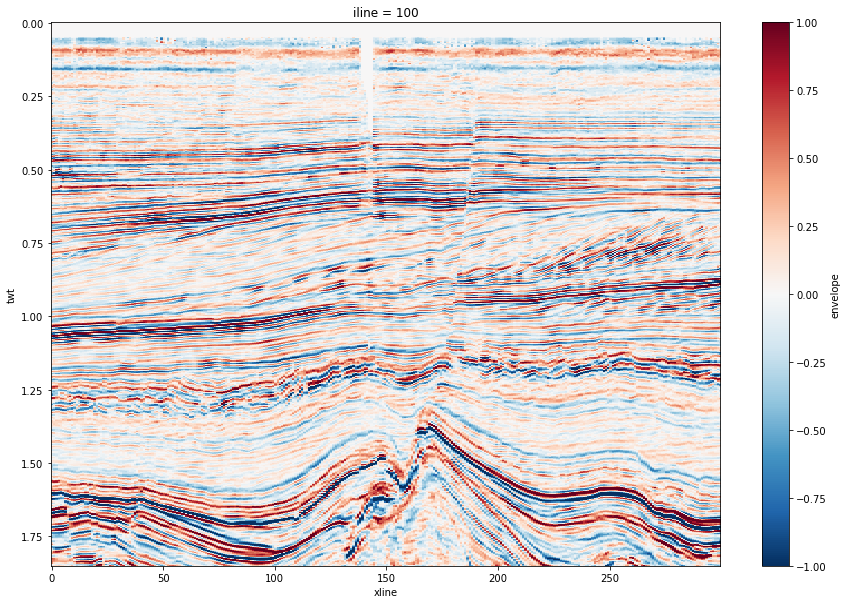

In [16]:
plt.figure(figsize=(15, 10))
env_xr[100].T.plot.imshow(origin='upper')

You could also add it to a `DataSet`:

In [12]:
# Make a Dataset for the original amplitude data:
ds = xr.Dataset({'amplitude': seismic_xr})
ds['envelope'] = env_xr
ds

<xarray.Dataset>
Dimensions:    (iline: 225, xline: 300, twt: 463)
Coordinates:
  * iline      (iline) int64 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223 224
  * xline      (xline) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * twt        (twt) float64 0.0 0.004 0.008 0.012 ... 1.836 1.84 1.844 1.848
Data variables:
    amplitude  (iline, xline, twt) float64 0.0 0.0 0.0 ... 1.0 0.4882 0.03937
    envelope   (iline, xline, twt) float64 0.0 0.0 0.0 ... 1.0 0.4882 0.03937

---

&copy; Agile Scientific 2021 &mdash; licensed CC BY / Apache 2.0